## Training example 

I've got a few of questions of dataset processing and training for this repo. I hope this example to be helpful for people who have asked. Thanks.


Dataset  
  - Download link : http://shuoyang1213.me/WIDERFACE/
  
And then, place the dataset like below 

-- BUG Report
    : Now Bounding box and Anchor are using different format.
    
```Bounding box = x_0, y_1, w, h // Anchor = x_c, y_c, w, h```



In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np 
import cv2
import glob
import os 
import sys 
sys.path.append('implementation/')

/Users/hyunkim/.pyenv/versions/3.6.9/envs/python36/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from implementation.main import BlazeFace
from implementation.anchor import generate_anchors

In [3]:
class tempConfigs:
    def __init__(self):
        pass 
    
    def add_argument(self, args_name, value):
        exec(f"self.{args_name} = {value}")
        
args = tempConfigs()

args.add_argument('input_shape', [128, 128, 3])
args.add_argument('batch_size', 64)
args.add_argument('nb_epoch', 1000)
args.add_argument('train', True)
args.add_argument('checkpoint_path', None)
args.add_argument('numdata', None)
args.add_argument('dataset_dir', None)
args.add_argument('label_path', None)

#### :: Define model

In [5]:
model = BlazeFace(args).build_model()
model.output

<tf.Tensor 'concatenate_5/concat:0' shape=(None, 896, 5) dtype=float32>

#### :: Anchor preparation 

In [6]:
strides = [8, 16, 16, 16]
# "strides" means that, 
# for example, 
# if I want to make predictions on 16x16 feature map 
# and the input image was 128x128 
# then the stride for this is "8" (128 / 8 = 16)

anchor_options = {
    "num_layers": len(strides),
    "min_scale": 0.05,
    "max_scale": 0.70,
    "input_size_height": 128,
    "input_size_width": 128,
    "anchor_offset_x": 0.5,
    "anchor_offset_y": 0.5,
    "strides": strides,
    "aspect_ratios": [1.0, 1.5], # if use_only_square==True then, I will be simply multipied to height and width
    "reduce_boxes_in_lowest_layer": False,
    "interpolated_scale_aspect_ratio": 0.0,
    "fixed_anchor_size": False,
    "use_only_square" : True,
}

In [7]:
default_anchors = generate_anchors(anchor_options)

In [8]:
default_anchors.shape

(896, 4)

#### :: Data preparation

In [9]:
imagedatalist = []
for d in glob.glob("./dataset/WIDER_train/images/*"):
    imagedatalist += glob.glob(d + "/*.*")

In [10]:
len(imagedatalist), imagedatalist[:5]

(12880,
 ['./dataset/WIDER_train/images/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_139.jpg',
  './dataset/WIDER_train/images/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_893.jpg',
  './dataset/WIDER_train/images/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_105.jpg',
  './dataset/WIDER_train/images/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_307.jpg',
  './dataset/WIDER_train/images/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_14.jpg'])

In [11]:
# label txt 
label_txts = [
    "./dataset/wider_face_split/wider_face_train_bbx_gt.txt",
#     "./dataset/wider_face_split/wider_face_val_bbx_gt.txt",
             ]

raw_label = []
for label_txt in label_txts:
    with open(label_txt, 'r') as f:
        raw_label += f.readlines()

In [12]:
label_dict = {}
filenameIdx = 0
while filenameIdx < len(raw_label):
    numOfFaces = int(raw_label[filenameIdx+1].replace("\n", ""))
    if numOfFaces > 0: 
        bboxes = []
        for i in range(filenameIdx+2, filenameIdx+2+numOfFaces):
            temp = raw_label[i].split(" ")
            bboxes.append([int(x) for x in temp[:4]])
            
        label_dict[raw_label[filenameIdx].replace("\n", "")] = bboxes
        filenameIdx += 2 + numOfFaces
    else: 
        label_dict[raw_label[filenameIdx]] = []
        filenameIdx += 3

#### :: data sample check

In [13]:
def getFileID(path):
    return "/".join(path.split('/')[-2:])

def read_img(path):
    return cv2.imread(path)[:,:,::-1]

import matplotlib.patches as patches

def draw_image_and_rectangle(img, boxes, single_box=False):
    fig,ax = plt.subplots(1, figsize=(9,9))
    ax.imshow(img)
    cmap = plt.cm.get_cmap("hsv", len(boxes))
    
    if single_box:
        boxes = [boxes]
    
    for i, box in enumerate(boxes):
        rec = patches.Rectangle([box[0], box[1]],
                                box[2], box[3],
                                linewidth=1, 
                                edgecolor=cmap(i), 
                                facecolor='none')
        ax.add_patch(rec)

    plt.show()
    return None

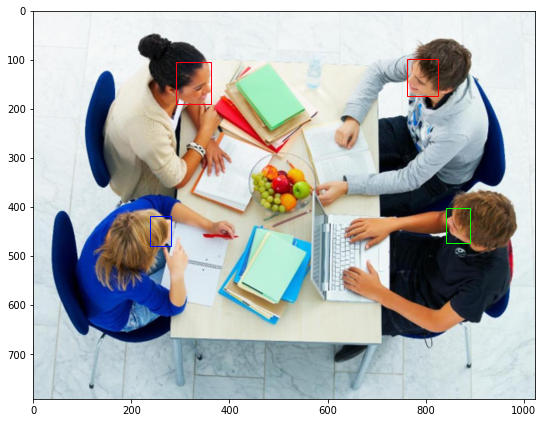

In [14]:
item = imagedatalist[0]
sample_img = read_img(item)
sample = label_dict[getFileID(item)]

draw_image_and_rectangle(sample_img, sample)

#### :: Matching anchors and bounding boxes

In [22]:
def compute_IOU(box1, box2):
    """
    Box components not to be 0 ~ 1 scale. Because of multiplying operation to get area. 
    """
    boxA = [box1[0] - box1[2]/2, box1[1] - box1[3]/2, box1[0] + box1[2]/2, box1[1] + box1[3]/2,]
    boxB = [box2[0] - box2[2]/2, box2[1] - box2[3]/2, box2[0] + box2[2]/2, box2[1] + box2[3]/2,]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))
    iou = interArea / np.float(boxAArea + boxBArea - interArea)
    return iou

def scale_bbox(x, shape):
    h, w = shape
    return [x[0]/w, x[1]/h, x[2]/w, x[3]/h]

def descale_bbox(x, shape):
    h, w = shape
    return [x[0]*w, x[1]*h, x[2]*w, x[3]*h]

def x1y1ToxCyC(x):
    return [x[0]+x[2]/2, x[1]+x[3]/2 , x[2], x[3]]

def xCyCTox1y1(x):
    return [x[0]-x[2]/2, x[1]-x[3]/2 , x[2], x[3]]

def encode_bbox(bbox, anchor):
    new_bbox = np.zeros(4)
    new_bbox[0] = (bbox[0] - anchor[0]) / (1. * anchor[2])
    new_bbox[1] = (bbox[1] - anchor[1]) / (1. * anchor[3])
    new_bbox[2] = np.log(bbox[2] / anchor[2]) / 2.
    new_bbox[3] = np.log(bbox[3] / anchor[3]) / 2.
    return new_bbox

def decode_bbox(bbox, anchor):
    new_bbox = np.zeros(4)
    new_bbox[0] = (bbox[0] * anchor[2]) + anchor[0]
    new_bbox[1] = (bbox[1] * anchor[3]) + anchor[1]
    new_bbox[2] = np.exp(bbox[2] * 2) * anchor[2]
    new_bbox[3] = np.exp(bbox[3] * 2) * anchor[3]
    return new_bbox


In [39]:
IOU_threshold = 0.2
X = []
Y_e = []
Y_b = []

for item in imagedatalist:
    img = read_img(item)
    h, w, _ = img.shape
    resized_img = cv2.resize(img, dsize=tuple(args.input_shape[:2]))
    th, tw, _ = resized_img.shape
    
    try:
        boxes = label_dict[getFileID(item)]
    except:
        print("__ NO LABEL__")
        continue

    label_exist = np.zeros(default_anchors.shape[0])
    scaled_box = np.array([scale_bbox(x, (h, w)) for x in boxes])
    descaled_box = np.array([descale_bbox(x, (th, tw)) for x in scaled_box])
    centeric_box = np.array([x1y1ToxCyC(x) for x in descaled_box])
    descaled_anchors = np.array([descale_bbox(x, (th, tw)) for x in default_anchors])
    label_boxes = descaled_anchors.copy()
    anchor_id_and_iou_dict = {}
    for box in centeric_box:
        for i, anchor in enumerate(descaled_anchors):
            iou = compute_IOU(box, anchor)
            if IOU_threshold < iou:
                if label_exist[i] == 1.:
                    if anchor_id_and_iou_dict[i] > iou:
                        continue
                        
                label_exist[i] = 1.
                label_boxes[i] = encode_bbox(box, anchor)
                anchor_id_and_iou_dict[i] = iou
            else:
                continue
                
    X.append(resized_img)
    Y_e.append(label_exist)
    Y_b.append(label_boxes)
#     break

KeyboardInterrupt: 

In [40]:
X, Y = np.array(X), np.concatenate([np.array(Y_e)[:,:,np.newaxis], np.array(Y_b)], axis=-1)

X.shape, Y.shape

((49, 128, 128, 3), (49, 896, 5))

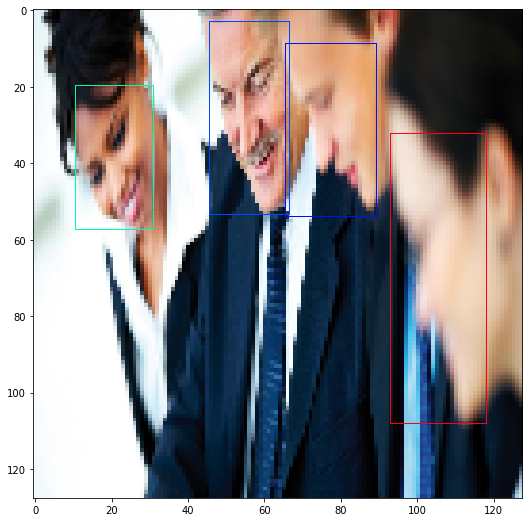

In [41]:
ix = -2
temps = []
for i, e in enumerate(Y_e[ix]):
    if e:
        box = decode_bbox(Y_b[ix][i], descaled_anchors[i])
        temps.append(xCyCTox1y1(box))
        
draw_image_and_rectangle(X[ix], temps)

#### :: Model Fitting 

In [42]:
def focal_loss(alpha=0.25, gamma=2):
    
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

    def lossFunc(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))

        loss_ = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
        # or reduce_sum and/or axis=-1
        return tf.reduce_mean(loss_, axis=-1)

    return lossFunc

def smooth_l1(y_true, y_pred):
    absolute_value_loss = tf.math.abs(y_true - y_pred) - 0.5
    square_loss = 0.5 * (y_true - y_pred)**2
    absolute_value_condition = tf.less(absolute_value_loss, 1.0)
    l1_smooth_loss = tf.where(absolute_value_condition, square_loss, absolute_value_loss)
    return tf.reduce_sum(l1_smooth_loss, axis=-1)

def lossFunc(y_true, y_pred):
    """
    y_true.shape = (batch, NumAnc, 5))
    """
    gt_classes = y_true[:,:,:1] # (batch_size, NumofAnchors, 1)
    gt_boxes = y_true[:,:,1:1+4] # (batch_size, NumofAnchors, 4)
    
    pr_classes = y_pred[:,:,:1]
    pr_boxes = y_pred[:,:,1:1+4]
    
    batch_size  = tf.shape(gt_classes)[0]
    anchor_num = tf.shape(gt_classes)[1]
    total_num = tf.ones([batch_size], dtype=tf.int64) * tf.cast(anchor_num, tf.int64)
    
    # ======= Conf loss =======
    positives_num = tf.compat.v1.count_nonzero(gt_classes[:,:,0], axis=1)
    negatives_num = total_num - positives_num

    positives_num_safe = tf.where(tf.equal(positives_num, 0),
                              tf.ones([batch_size])*10e-15,
                              tf.cast(positives_num, tf.float32))

    negatives_mask = tf.equal(gt_classes[:,:,0], 0)
    # Shape: (batch_size, num_anchors)
    positives_mask = tf.logical_not(negatives_mask)
    
    #Focal loss. 
    fc_loss = focal_loss()(gt_classes, pr_classes)
    # Shape: (batch_size, num_anchors)
    positives = tf.where(positives_mask, fc_loss, tf.zeros_like(fc_loss))
    # Shape: (batch_size)
    positives_sum = tf.reduce_sum(positives, axis=-1)
    
    negatives = tf.where(negatives_mask, fc_loss, tf.zeros_like(fc_loss))
    # Shape: (batch_size, num_anchors)
    negatives_top = tf.nn.top_k(negatives, anchor_num)[0]
    # Maximum number of negatives to keep per sample - we keep at most
    # 3 times as many as we have positive anchors in the sample
    negatives_num_max = tf.minimum(negatives_num, 3 * positives_num)
    
    negatives_num_max_t = tf.expand_dims(negatives_num_max, 1)
    rng = tf.range(0, anchor_num, 1)
    range_row = tf.compat.v1.to_int64(tf.expand_dims(rng, 0))
    negatives_max_mask = tf.less(range_row, negatives_num_max_t)
    # Shape: (batch_size, num_anchors)
    negatives_max = tf.where(negatives_max_mask, negatives_top,
                                     tf.zeros_like(negatives_top))
    negatives_max_sum = tf.reduce_sum(negatives_max, axis=-1)
    confidence_loss_sum = tf.add(positives_sum, negatives_max_sum)
    confidence_loss_sum = tf.cast(confidence_loss_sum, tf.float32)
    confidence_loss = tf.where(tf.equal(positives_num, 0),
                               tf.zeros([batch_size]),
                               tf.math.divide(confidence_loss_sum, positives_num_safe))

    # Bounding box regresssion Loss
    
    box_loss = smooth_l1(gt_boxes, pr_boxes)
    
    positive_box = tf.where(positives_mask, box_loss,
                             tf.zeros_like(box_loss))
    positive_box_loss_sum = tf.cast(tf.reduce_sum(positive_box, axis=-1), tf.float32)

    positive_box_loss = tf.where(tf.equal(positives_num, 0),
                                 tf.zeros([batch_size]),
                                 tf.math.divide(positive_box_loss_sum, positives_num_safe))

    class_box_loss = tf.math.add(tf.math.multiply(confidence_loss, 1.), positive_box_loss)

    return class_box_loss


In [43]:
opt = tf.keras.optimizers.Adam(lr=0.003, amsgrad=True)
model.compile(
    loss=lossFunc,
    optimizer=opt)

In [44]:
model.fit(X, Y, batch_size=64, epochs=10)

Epoch 1/10
Instructions for updating:
Use `tf.cast` instead.
1/1 [==============================] - 0s 4ms/step - loss: 25.9923
Epoch 2/10
1/1 [==============================] - 0s 939us/step - loss: 22.6246
Epoch 3/10
1/1 [==============================] - 0s 920us/step - loss: 7.7024
Epoch 4/10
1/1 [==============================] - 0s 978us/step - loss: 4.9947
Epoch 5/10
1/1 [==============================] - 0s 933us/step - loss: 4.1457
Epoch 6/10
1/1 [==============================] - 0s 903us/step - loss: 3.2917
Epoch 7/10
1/1 [==============================] - 0s 1ms/step - loss: 2.7937
Epoch 8/10
1/1 [==============================] - 0s 938us/step - loss: 2.4176
Epoch 9/10
1/1 [==============================] - 0s 1ms/step - loss: 2.1172
Epoch 10/10
1/1 [==============================] - 0s 923us/step - loss: 1.9136


In [45]:
model.save("./test.h5")

In [46]:
model.load_weights("./test.h5")

#### :: Evaluation

In [47]:
def decode_bbox_Mutilple(bbox, anchor):
    
    new_bbox = np.zeros((bbox.shape[0], 4))

    for i in range(bbox.shape[0]):
        new_bbox[i] = decode_bbox(bbox[i], anchor[i])

    return new_bbox

def iou_one_with_the_others(box1, boxes_):
    """
    box1 = cx , cy, w, h
    boxes = [N, 4]
    """
    boxA = [box1[0] - box1[2]/2, box1[1] - box1[3]/2, box1[0] + box1[2]/2, box1[1] + box1[3]/2,]
    boxes = np.ones_like(boxes_)
    boxes[:,0] = boxes_[:,0] - boxes_[:,2]/2
    boxes[:,1] = boxes_[:,1] - boxes_[:,3]/2
    boxes[:,2] = boxes_[:,0] + boxes_[:,2]/2
    boxes[:,3] = boxes_[:,1] + boxes_[:,3]/2
    
    xA = np.maximum(boxA[0], boxes[:, 0])
    yA = np.maximum(boxA[1], boxes[:, 1])
    xB = np.minimum(boxA[2], boxes[:, 2])
    yB = np.minimum(boxA[3], boxes[:, 3])
    
    interArea = np.abs(np.maximum((xB - xA), 0) * np.maximum((yB - yA), 0))
    
    boxAArea = np.abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = np.abs((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))
    
    iou = interArea / (boxAArea + boxBArea - interArea)
    
    zero_inter_mask = interArea == 0
    iou[zero_inter_mask] = 0.
    
    return iou


In [48]:
def weighted_non_max_suppression(outputs, default_anchor, classId=1, scaler=1, min_suppression_threshold=0.3):

    output_detections = []

    if len(outputs) == 0: return []

    candidate_id = np.arange(outputs.shape[0])[np.where(outputs[:,0] > 0.2, 1., 0.) == classId]
    detections = np.array(outputs)[candidate_id]
    
    detections[:, 1:1+4] = decode_bbox_Mutilple(detections[:, 1:1+4], default_anchor[candidate_id]) * scaler
    
    remaining = np.argsort(detections[:, 0])
    
    while len(remaining) > 0:
        detection = detections[remaining[-1]]
        first_box = detection[1:1+4]
        other_boxes = detections[remaining, 1:1+4]
        ious = iou_one_with_the_others(first_box, other_boxes)
        mask = ious > min_suppression_threshold
        overlapping = remaining[mask]
        remaining = remaining[~mask]
    
        weighted_detection = np.zeros_like(detection)
        weighted_detection[:] = detection[:]
        
        if len(overlapping) > 1:
            coordinates = detections[overlapping, 3:]
            scores = detections[overlapping, classId:classId+1]
            total_score = scores.sum()
            weighted = (coordinates * scores).sum(axis=0) / total_score
            weighted_detection[3:] = weighted
            weighted_detection[:3] = 0.
            weighted_detection[classId] = total_score / len(overlapping)
            
        output_detections.append(weighted_detection)

    return output_detections

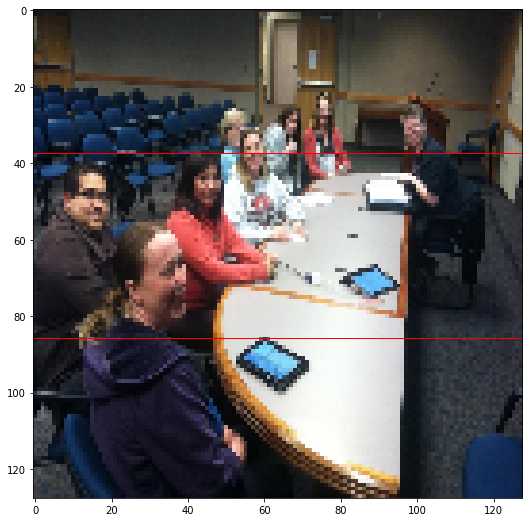

In [52]:
fig,ax = plt.subplots(1, figsize=(9,9))
ix = 2

ax.imshow(X[ix])
res = model.predict(X[ix:ix+1])[0]

predictions = weighted_non_max_suppression(res, descaled_anchors, classId=1, scaler=1.)
for pred in predictions[:1]:
    xy = (pred[1+0] - pred[1+2]/2, pred[1+1] - pred[1+3]/2)
    rec = patches.Rectangle(xy, pred[1+2], pred[1+3], linewidth=1, edgecolor="r", facecolor='none')
    ax.add_patch(rec)
plt.show()